# Recommendation Systems Assignment

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [ ]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Support functions and variables

In [ ]:
wget.download("http://files.grouplens.org/datasets/movielens/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [ ]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1 Data Preprocessing and Baseline algorithms

### (a)

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [ ]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
          # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
            # select the row for user
            # what's the shape of userVector
              userVector = train_matrix[user, :]
            
            # Extract the items the user already rated 
            ## dimension 1 x num of movies rated, filter out all movies that have been rated
              ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
              if ratedItems.size == 0:
                  itemAvg = 0
              else:
                  itemAvg = ratedItems.mean()
              predictionMatrix[user, item] = itemAvg
            
          # report progress every 100 users
            #if (user % 100 == 0 and item == 1):
              #print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
          numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
          numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
          if numOfUsersRated == 0:
             itemPopularity[item] = 0
          else:
             itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    
        for (user,item), rating in np.ndenumerate(train_matrix):
          # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]
            
          # report progress every 100 users
          #if (user % 100 == 0 and item == 1):
              #print ("calculated %d users" % (user,))        
                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [ ]:
popularity_recsys = BaseLineRecSys('popularity')

In [ ]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [ ]:
x = popularity_recsys.getModel()

In [ ]:
np.all(x<=1)

True

In [ ]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:29, 1117.18it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [ ]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [ ]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:28, 1125.57it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2 Similarity in Collaborative Filtering

### (a)

In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        
        
        # Euclidean distance = sqrt(sumitem(xi-yi)^2)
        # the Euclidean similarity = 1 / (1+euclidean distance), range between [0,1]
        # reference: https://stats.stackexchange.com/questions/53068/euclidean-distance-score-and-similarity
        
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric = 'euclidean'))
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        
        # Manhattan distance is the sum of the lengths of the 'right angle' formed by the two points
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric = 'manhattan'))
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
             # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            # UxU mul UxI = UxI
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #print(predictionMatrix)
            
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average
            
            ### ??? + 1e-5 or not??
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            self.__model = predictionMatrix

  
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix.transpose())
            
            # IxU: IxI mul IxU
            normalizer = np.matmul(ii_similarity, temp_matrix.transpose())
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            
            # IxI mul IxU
            predictionMatrix = np.matmul(ii_similarity, train_matrix.transpose())/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no item has been rated by this user before, use item average
            
            ### ??? + 1e-5 or not?? 
            itemaverage = np.sum(train_matrix.transpose(), axis=1)/(np.sum(temp_matrix.transpose(), axis=1) +1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            
            self.__model = predictionMatrix.transpose()
            ###########         end         ###########
        else:
            print('No other option available')
        
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

(a) Cosine similarity is better since it is measured by the angle between vectors which would not be affected by the length of the vector whereas the other one concern with the distance which can be affected by vector length significantly. 

Ref: 
https://www.machinelearningplus.com/nlp/cosine-similarity/

"The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance because of the size (like, the word ‘cricket’ appeared 50 times in one document and 10 times in another) they could still have a smaller angle between them. Smaller the angle, higher the similarity."



In [ ]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

### (b)

Manhattan distance is the total sum of the absolute value of the difference between the x-coordinates and y-coordinates and by taking its inverse we are able to see how far away (or similar) two users or items are, similary to the euclidean similarity. Also, if the dimension of the matrix is high, manhattan distance would work well. 

Additionally, when you want to place less emphasis on outliers, the manhattan distance will try to reduce all errors equally (as the gradient has constant magnitude).

Ref: https://datascience.stackexchange.com/questions/20075/when-would-one-use-manhattan-distance-as-opposite-to-euclidean-distance

https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions/99191#99191

## Q3 Collaborative Filtering

### (a)

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [ ]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [ ]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [ ]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:44, 961.15it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### (b)

In [ ]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [ ]:
# How to use CrossValidation Class?

In [ ]:
# 1. gather your algorithms in previous steps.
#algorithm_instances = [popularity_recsys, 
                       #average_user_rating_recsys, 
                       #user_cosine_recsys]

item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]

In [ ]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('P@K')

In [ ]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


20000it [00:09, 2132.56it/s]
20000it [00:09, 2123.47it/s]
20000it [00:09, 2102.27it/s]
20000it [00:09, 2128.69it/s]
20000it [00:10, 1986.87it/s]


Processing algorithm user-cosine


20000it [00:09, 2116.85it/s]
20000it [00:09, 2119.20it/s]
20000it [00:09, 2118.74it/s]
20000it [00:09, 2120.03it/s]
20000it [00:09, 2083.35it/s]


{'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943]}

In [ ]:
#user_cosine_recsys = SimBasedRecSys('user','cosine')
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_rmse = CrossValidation('RMSE')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.

results = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


20000it [00:09, 2102.48it/s]
20000it [00:09, 2088.25it/s]
20000it [00:09, 2091.61it/s]
20000it [00:09, 2072.58it/s]
20000it [00:09, 2122.55it/s]


Processing algorithm user-cosine


20000it [00:09, 2142.64it/s]
20000it [00:09, 2121.64it/s]
20000it [00:09, 2129.17it/s]
20000it [00:09, 2078.10it/s]
20000it [00:09, 2115.04it/s]


In [ ]:
print('user-user RMSE average: ', results.get('user-cosine')[1])
print('user-user RMSE confidence interval: (',results.get('user-cosine')[2], ',',results.get('user-cosine')[3],')')

print('item-item RMSE average: ', results.get('item-cosine')[1])
print('item-item RMSE confidence interval: (',results.get('item-cosine')[2], ',',results.get('item-cosine')[3],')')


user-user RMSE average:  1.017354121469863
user-user RMSE confidence interval: ( 1.0090130800118484 , 1.0256951629278774 )
item-item RMSE average:  1.020082900106248
item-item RMSE confidence interval: ( 1.0068242686250732 , 1.0333415315874226 )


Q3(b) User-user performed better. We have 943 users and 1682 items, so the user dimension is more dense than the item dimension. Thus the user-user similarity could be more accurate than item-item which can result in a better prediction. 

## Q4 Probabilistic Matrix Factorization(PMF)

### (a)

In [ ]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = 0.1*np.random.randn(num_item, self.num_feat)  # item M x D 
        self.w_User = 0.1*np.random.randn(num_user,self.num_feat)  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########            
                
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],self.w_Item[batch_ItemID, :]),axis = 1) #size (batch_size, )            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :],self.w_Item[train_item_idx, :]), axis = 1) # size(pairs_train, )      
 

                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :],self.w_Item[val_item_idx, :]), axis = 1) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 17, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False}) # maxepoch for rest q's = 17 originally

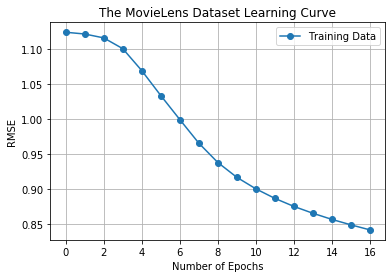

In [ ]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5 Performance Comparison

### (a)

In [ ]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys, 
                       item_cosine_recsys, 
                       pmf]

#algorithm_instances = [user_cosine_recsys, 
#                       pmf]

evl_metrics = ['RMSE','P@K','R@K']

instance_list = ['popularity', 
                 'useraverage', 
                 'user-cosine',
                 'item-cosine',
                 'PMF']
results = []
for evl in evl_metrics: 
  cv = CrossValidation(evl)
  results.append(cv.run(algorithm_instances, num_users, num_items,k=5))

Processing algorithm popularity


20000it [00:09, 2020.89it/s]
20000it [00:09, 2093.76it/s]
20000it [00:09, 2124.97it/s]
20000it [00:09, 2062.71it/s]
20000it [00:09, 2084.71it/s]


Processing algorithm useraverage


20000it [00:09, 2118.53it/s]
20000it [00:09, 2016.70it/s]
20000it [00:09, 2120.99it/s]
20000it [00:09, 2149.05it/s]
20000it [00:09, 2156.35it/s]


Processing algorithm user-cosine


20000it [00:09, 2098.14it/s]
20000it [00:09, 2113.20it/s]
20000it [00:09, 2054.33it/s]
20000it [00:09, 2115.27it/s]
20000it [00:09, 2134.54it/s]


Processing algorithm item-cosine


20000it [00:09, 2024.15it/s]
20000it [00:09, 2118.32it/s]
20000it [00:09, 2088.10it/s]
20000it [00:09, 2091.13it/s]
20000it [00:09, 2116.66it/s]


Processing algorithm PMF


20000it [00:16, 1177.74it/s]
20000it [00:16, 1207.00it/s]
20000it [00:16, 1189.20it/s]
20000it [00:17, 1159.38it/s]
20000it [00:16, 1190.18it/s]


Processing algorithm popularity


20000it [00:09, 2136.74it/s]
20000it [00:09, 2090.91it/s]
20000it [00:09, 2154.59it/s]
20000it [00:09, 2140.53it/s]
20000it [00:09, 2172.22it/s]


Processing algorithm useraverage


20000it [00:09, 2159.89it/s]
20000it [00:09, 2157.50it/s]
20000it [00:09, 2147.05it/s]
20000it [00:09, 2160.49it/s]
20000it [00:09, 2097.69it/s]


Processing algorithm user-cosine


20000it [00:09, 2146.47it/s]
20000it [00:09, 2116.20it/s]
20000it [00:09, 2117.33it/s]
20000it [00:09, 2089.14it/s]
20000it [00:09, 2133.28it/s]


Processing algorithm item-cosine


20000it [00:09, 2134.61it/s]
20000it [00:09, 2138.01it/s]
20000it [00:09, 2091.04it/s]
20000it [00:09, 2102.20it/s]
20000it [00:09, 2110.62it/s]


Processing algorithm PMF


20000it [00:16, 1193.31it/s]
20000it [00:16, 1182.70it/s]
20000it [00:16, 1231.43it/s]
20000it [00:16, 1226.65it/s]
20000it [00:16, 1223.63it/s]


Processing algorithm popularity


20000it [00:09, 2105.67it/s]
20000it [00:09, 2105.05it/s]
20000it [00:09, 2102.79it/s]
20000it [00:09, 2047.50it/s]
20000it [00:09, 2079.36it/s]


Processing algorithm useraverage


20000it [00:09, 2160.39it/s]
20000it [00:09, 2136.89it/s]
20000it [00:09, 2147.13it/s]
20000it [00:09, 2028.66it/s]
20000it [00:09, 2138.14it/s]


Processing algorithm user-cosine


20000it [00:09, 2140.04it/s]
20000it [00:09, 2176.01it/s]
20000it [00:09, 2142.86it/s]
20000it [00:09, 2157.47it/s]
20000it [00:09, 2151.79it/s]


Processing algorithm item-cosine


20000it [00:09, 2080.27it/s]
20000it [00:09, 2098.64it/s]
20000it [00:09, 2114.12it/s]
20000it [00:10, 1965.53it/s]
20000it [00:09, 2096.01it/s]


Processing algorithm PMF


20000it [00:16, 1184.08it/s]
20000it [00:17, 1169.25it/s]
20000it [00:16, 1180.01it/s]
20000it [00:16, 1194.64it/s]
20000it [00:16, 1210.64it/s]


In [ ]:
#for i in range(3): 
  #for ins, res in results[i].items():
    #print('average of ', evl_metrics[i], ' for ', ins, ' is ', res[1])
    #print('confidence interval of ', evl_metrics[i], ' for ', ins, ' is (', res[2], ',', res[3], ')')

for i in range(3): 
  print(evl_metrics[i],":")
  for ins, res in results[i].items(): 
    print(ins, ' average: ', res[1])
    print(ins, ' confidence interval: ', '(', res[2], ',', res[3], ')')
  print('\n')

RMSE :
popularity  average:  3.1590928909890112
popularity  confidence interval:  ( 3.139292746995387 , 3.1788930349826354 )
useraverage  average:  1.0437176561595025
useraverage  confidence interval:  ( 1.0289303496379316 , 1.0585049626810734 )
user-cosine  average:  1.017354121469863
user-cosine  confidence interval:  ( 1.0090130800118484 , 1.0256951629278774 )
item-cosine  average:  1.020082900106248
item-cosine  confidence interval:  ( 1.0068242686250732 , 1.0333415315874226 )
PMF  average:  0.9429437612536613
PMF  confidence interval:  ( 0.9266472856027127 , 0.9592402369046099 )


P@K :
popularity  average:  0.5505832449628855
popularity  confidence interval:  ( 0.40544114481568705 , 0.6957253451100839 )
useraverage  average:  0.4736373276776259
useraverage  confidence interval:  ( 0.3419993013451059 , 0.6052753540101459 )
user-cosine  average:  0.5558430540827157
user-cosine  confidence interval:  ( 0.40959849499983714 , 0.7020876131655943 )
item-cosine  average:  0.5322163308589

### (b)

Q5 (b)

Popularity cannot be evaluated by RMSE. It could be because the popularity is calculated by the percentage of users who rated the movie above 4 out of all users who rated the item, and there is no numerical accuracy for such percentage. The scale is different, popularity is [0,1] whereas the actual rating is [1,5]. 

Alternatively, I think user average and popularity cannot be evaluated with P@k and R@k either. Because these two are ranking metrics, but user average and popularity do not actually have ranking. 

Q5 (c)

Best for RMSE: PMF;

PMF is best for the RMSE because it has an explicit objective function to optimize and the rating matrix is very large and sparse. 

Best for P@k: user-cosine; 


Best for R@k: user-cosine;  

User-cosine is better than PMF in P@k and R@k because the objective function that PMF explicitly optimizes is the squared errer not the P@k or R@k. User-cosine performs the best because the user dimension in the rating matrix is relatively more dense than the item dimension. Thus the user similarity score could be more reliable than others and gives better prediction. 


Q5 (d)
Good performance on RMSE implies good performance on ranking but not neccessarily vice versa. Because in recommender system, rating numerically accurate is not important, what the user needs is ranked results. 


## Q6 Similarity Evaluation

### (a)

In [ ]:
def getItemData(folder_path, file_name):
  
    #http://files.grouplens.org/datasets/movielens/ml-100k/u.item
    fields = ['movieId', 'movieTitle', 'releaseDate', 'videoReleaseDate', 
              'IMDbURL',  'unknown', 'Action',  'Adventure',  'Animation', 
              'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
              'Film-Noir', 'Horror', 'Musical',  'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']
    
    # Reference: https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='|', names=fields,encoding='latin-1')
    return data 



In [ ]:
movies_df = getItemData(MOVIELENS_DIR, 'u.item')

In [ ]:
trainMatrix = dataPreprocessor(rating_df, num_users, num_items)
ii_similarity = SimBasedRecSys.cosine(trainMatrix.transpose())

In [ ]:
def top5Similar(ii_similarity, movie_name, movie_ID):
  # Referemces: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
  # https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
  similarity = ii_similarity[movie_ID-1]
  index = similarity.argsort()[::-1][1:6]
  
  # Ref: https://www.geeksforgeeks.org/python-map-function/
  # syntax: map(fun, iter), apply fun to each item in iter
  result = map(lambda x: movies_df[movies_df.movieId ==x+1]['movieTitle'].values[0],index)
  
  top5sim = list(result)
  
  print('The top 5 most similar movies of ', movie_name, 'are: \n', top5sim)
  
  

In [ ]:
top5Similar(ii_similarity, 'Snow White and the Seven Dwarfs',99)
top5Similar(ii_similarity, 'Batman Forever', 29)
top5Similar(ii_similarity, 'Sleepless in Seattle', 88)


The top 5 most similar movies of  Snow White and the Seven Dwarfs are: 
 ['Beauty and the Beast (1991)', 'Cinderella (1950)', 'Pinocchio (1940)', 'Fantasia (1940)', 'Dumbo (1941)']
The top 5 most similar movies of  Batman Forever are: 
 ['Batman (1989)', 'Batman Returns (1992)', 'Cliffhanger (1993)', 'Demolition Man (1993)', 'Stargate (1994)']
The top 5 most similar movies of  Sleepless in Seattle are: 
 ['While You Were Sleeping (1995)', 'Mrs. Doubtfire (1993)', 'Groundhog Day (1993)', 'When Harry Met Sally... (1989)', 'Dave (1993)']


### (b)

For most cases, the top 5 similar either fall into the same genres as the picked one or content-wise they are similar.  


'Snow White and the Seven Dwarfs' is animation, children's and musical, so are the 'Beauty and the Beast' and 'Cinderella', whereas 'Pinocchio' and 'Fantasia' are not musical but still animation and children's. However, 'Dumbo' has the exactly same genres as 'Snow Whie and the Seven Dwarfs', but it is just at top 5, I think the reason could be that the content of 'Dumbo' is not very similar to the Snow White, thus the users did not tend to rate them the same. Overall, they are Disney movies, users prefer one of them would be very likely to watch others and have similar satisfaction levels for them. 


For 'Batman Forever', the top two 'Batman' and 'Batman Returns' are the same serie of movies, thus users who are fans of Batman tend to watch them all and provide similar ratings. For 'Cliffhanger', it's in the same genres as 'Batman Forever' except it's not a comedy. 'Demolition Man' is action and sci-fi, only one overlap in genre as 'Batman Forever' (action), which I don't think it's so similar as the Batman movie. 'Stargate' has two overlaps in genre (action and adventure), but also two variations. But on the other hand, I think 'Batman Forever' is also a fantasy movie (and probably sci-fi), so that also makes sense to categorize the last three movies in top 5 as very similar to it as users may like that specific type of movies. 


'Sleepless in Seattle is a romantic movie telling how two people fall in love with each other just through listening to a radio program. In the top 5, 4 of them have exactly the same genres as 'Sleepless in Seattle', comedy and romance. The one exception is 'Mrs. Doubtfire', but for the content-wise, it is still similar to the picked one, family issue, meet someone and life changes etc. Categorizing them as similar items make sense since users are vely likely to watching most of them and providing similar ratings (i.e. have a constant tast over movies). 



## Q7 Testing with different user types

### (a)

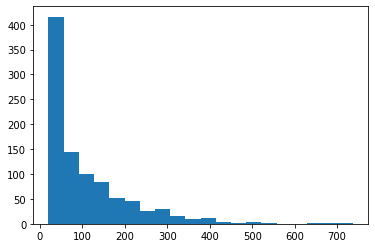

In [ ]:
temp_matrix = np.zeros(trainMatrix.shape)
temp_matrix[trainMatrix.nonzero()] = 1
num_items_rated = np.sum(temp_matrix, axis=1)

#print(trainMatrix.shape)
#print(num_items_rated)

plt.hist(num_items_rated, bins = 20)
plt.show()

The threshold tau is 60. 

In [ ]:
def predict_with_threshold(train_matrix, base):
        
        if base == 'user':
            ########### your code goes here ###########
             # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
            
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            # UxU mul UxI = UxI
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #print(predictionMatrix)
            
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average
            
            ### ??? + 1e-5 or not??
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            return predictionMatrix
          
            ###########         end         ###########
            
        elif base == 'item':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = 1 - pairwise_distances(train_matrix.transpose(), metric='cosine')
            
            # IxU: IxI mul IxU
            normalizer = np.matmul(ii_similarity, temp_matrix.transpose())
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            
            # IxI mul IxU
            predictionMatrix = np.matmul(ii_similarity, train_matrix.transpose())/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use item average
            
            ### ??? + 1e-5 or not?? 
            itemaverage = np.sum(train_matrix.transpose(), axis=1)/(np.sum(temp_matrix.transpose(), axis=1) +1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            
            return predictionMatrix.transpose()
            ###########         end         ###########
        else:
            print('No other option available')

In [ ]:
tau = 60

u1_base_df = getData(MOVIELENS_DIR, 'u1.base')
u1_test_df = getData(MOVIELENS_DIR, 'u1.test')

u2_base_df = getData(MOVIELENS_DIR, 'u2.base')
u2_test_df = getData(MOVIELENS_DIR, 'u2.test')

u3_base_df = getData(MOVIELENS_DIR, 'u3.base')
u3_test_df = getData(MOVIELENS_DIR, 'u3.test')

u4_base_df = getData(MOVIELENS_DIR, 'u4.base')
u4_test_df = getData(MOVIELENS_DIR, 'u4.test')

u5_base_df = getData(MOVIELENS_DIR, 'u5.base')
u5_test_df = getData(MOVIELENS_DIR, 'u5.test')

In [ ]:
base_list = [u1_base_df,u2_base_df,u3_base_df,u4_base_df,u5_base_df]

test_list = [u1_test_df,u2_test_df,u3_test_df,u4_test_df,u5_test_df]

# Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html

# count the number of ratings per user, group by users and drop the other two columns

count_ratings = rating_df.groupby('userID').count().reset_index()
count_ratings.drop('itemID',axis=1,inplace=True)
count_ratings.drop('timestamp',axis=1,inplace=True)

count_ratings # used for split the dataframe by threshold

,userID,rating
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175
...,...,...
938,939,49
939,940,107
940,941,22
941,942,79


In [ ]:
def split_above_threshold(count_ratings, df, threshold): 
  df_above = df[df['userID'].isin(count_ratings[count_ratings['rating']>=threshold]['userID'].tolist())]  
  return df_above

def split_below_threshold(count_ratings, df, threshold): 
  df_below = df[df['userID'].isin(count_ratings[count_ratings['rating']<threshold]['userID'].tolist())]  
  return df_below

In [ ]:
base_list = [u1_base_df, u2_base_df,u3_base_df, u4_base_df, u5_base_df]
test_list = [u1_test_df, u2_test_df,u3_test_df, u4_test_df, u5_test_df]

split_base_above = []
split_test_above = []
split_base_below = []
split_test_below = []

for ds in base_list: 
  split_base_above.append(split_above_threshold(count_ratings,ds,tau))
  split_base_below.append(split_below_threshold(count_ratings,ds,tau))

for ds in test_list: 
  split_test_above.append(split_above_threshold(count_ratings,ds,tau))
  split_test_below.append(split_below_threshold(count_ratings,ds,tau))

base_above_matrix = []
base_below_matrix = []
test_above_matrix = []
test_below_matrix = []

for ds in split_base_above: 
   base_above_matrix.append(dataPreprocessor(ds, num_users, num_items))

for ds in split_base_below: 
   base_below_matrix.append(dataPreprocessor(ds, num_users, num_items))

for ds in split_test_above: 
   test_above_matrix.append(dataPreprocessor(ds, num_users, num_items))

for ds in split_test_below: 
   test_below_matrix.append(dataPreprocessor(ds, num_users, num_items))

# u.test is the ground truth  
results_uu_above = []
results_ii_above = []

results_uu_below = []
results_ii_below = []

for ds in base_above_matrix: 
  results_uu_above.append(predict_with_threshold(ds, 'user'))
  results_ii_above.append(predict_with_threshold(ds, 'item'))

for ds in base_below_matrix: 
  results_uu_below.append(predict_with_threshold(ds, 'user'))
  results_ii_below.append(predict_with_threshold(ds, 'item'))


#for i in range(len(base_above_matrix)): 
  #print('base ', i, 'high ', base_above_matrix[i].shape)
  #print('test ', i, 'high ', test_above_matrix[i].shape)


In [ ]:
rmse_uu_above = []
rmse_uu_below = []

rmse_ii_above = []
rmse_ii_below = []

for k in range(5): 
  rmse_uu_above.append(sqrt(mean_squared_error(results_uu_above[k][test_above_matrix[k].nonzero()], test_above_matrix[k][test_above_matrix[k].nonzero()])))
  rmse_uu_below.append(sqrt(mean_squared_error(results_uu_below[k][test_below_matrix[k].nonzero()], test_below_matrix[k][test_below_matrix[k].nonzero()])))
  rmse_ii_above.append(sqrt(mean_squared_error(results_ii_above[k][test_above_matrix[k].nonzero()], test_above_matrix[k][test_above_matrix[k].nonzero()])))
  rmse_ii_below.append(sqrt(mean_squared_error(results_ii_below[k][test_below_matrix[k].nonzero()], test_below_matrix[k][test_below_matrix[k].nonzero()])))

print('user-user above threshold: ')
for rs in rmse_uu_above: 
  print(rs)

print('\n')

print('user-user below threshold: ')
for rs in rmse_uu_below: 
  print(rs)

print('\n')

print('iterm-item above threshold: ')
for rs in rmse_ii_above: 
  print(rs)

print('\n')

print('item-item below threshold: ')
for rs in rmse_ii_below: 
  print(rs)

user-user above threshold: 
1.0222508497989067
1.0129894527257868
1.0079215342494896
1.0003440505046612
1.0132621432259783


user-user below threshold: 
1.0856180512843645
1.1115796009153012
1.0972227563443557
1.0983263790977529
1.1074091722054182


iterm-item above threshold: 
1.0414573747283948
1.0211881672744636
1.0075002492090388
1.0086623078722967
1.0179643938821543


item-item below threshold: 
1.1692417179982133
1.154541859294865
1.151801618051339
1.161450598600089
1.1297862711179716


For both user-user and item-item similarity, the rusults of above threshold are better (i.e. case(i) is better). Because when users have more rated items (the rating matix is more dense), the similarity scores between users and items are more reliable to make predictions (i.e. they are less likely to be affected by outliers). 

# Validation

In [ ]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [ ]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [ ]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [ ]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validatePopularityRecSys()

### User Average Based Recommendation

In [ ]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [ ]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [ ]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [ ]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [ ]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [ ]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [ ]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [ ]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [ ]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [ ]:
validatePMFRecSys(validation_df=validation_df)